In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [55]:
def get_cand_nodes(pos, rot, edge_range):
    cand_angles = [0, -30, 30]
    rot_axis = np.array([0, 1, 0])

    node_poses = []
    for angle in cand_angles:
        rot_vec = np.radians(-angle) * rot_axis
        unit_vec = -np.array([np.sin(rot_vec[1]), 0, np.cos(rot_vec[1])])
        cand_pos = pos + unit_vec * edge_range
        node_poses.append(cand_pos)
    return node_poses

In [61]:
pos = np.zeros(3)
# rot = np.zeros(3)
rot = np.array([0, np.deg2rad(30), 0])
edge_range = 1.

node_poses = get_cand_nodes(pos, rot, edge_range)

In [87]:
np.radians(30) * np.array([0, 1, 0])

array([0.        , 0.52359878, 0.        ])

In [92]:
for pose in node_poses:
    print(-np.arctan2(pose[0], -pose[2]))

-0.0
0.5235987755982988
-0.5235987755982988


In [93]:
total_node_poses = node_poses.copy()
target_poses = node_poses.copy()
next_target_poses = node_poses.copy()

for j in range(4):
    target_poses = next_target_poses
    next_target_poses = []
    
    for node_pose in target_poses:
        done_poses.append(node_pose)
        temp_node_poses = get_cand_nodes(node_pose, rot, edge_range)
        for temp_node_pose in temp_node_poses:
            if min(np.linalg.norm(np.array(total_node_poses) - temp_node_pose, axis=1)) > 0.5:
                total_node_poses.append(temp_node_pose)
                next_target_poses.append(temp_node_pose)

total_node_rots = []
for pose in total_node_poses:
    total_node_rots.append(-np.arctan2(pose[0], -pose[2]))
#     print(np.rad2deg(-np.arctan2(pose[0], -pose[2])))

-0.0
29.999999999999996
-29.999999999999996
-0.0
14.999999999999998
-14.999999999999998
29.999999999999996
-29.999999999999996
-0.0
9.8960906389829
-9.8960906389829
20.103909361017095
-20.103909361017095
29.999999999999996
-29.999999999999996
-0.0
7.369259787569941
-7.369259787569941
14.999999999999998
-14.999999999999998
22.63074021243005
-22.63074021243005
29.999999999999996
-29.999999999999996
-0.0
5.866738789543951
-5.866738789543951
11.932462708024955
-11.932462708024955
18.067537291975043
-18.067537291975043
24.133261210456045
-24.133261210456045
29.999999999999993
-29.999999999999993


In [97]:
len(total_node_poses)

35

In [77]:
rot_vec = np.array([0, np.deg2rad(90), 0])
rot = R.from_rotvec(rot_vec)
rot.as_matrix()
rot_node_poses = rot.apply(np.array(total_node_poses))

In [78]:
min_distance = float('inf')
for i in range(len(rot_node_poses)):
    for j in range(i+1, len(rot_node_poses)):
        distance = np.linalg.norm(rot_node_poses[i] - rot_node_poses[j])
        if distance < min_distance:
            min_distance = distance

print("Minimum Euclidean Distance:", min_distance)

Minimum Euclidean Distance: 0.5176380902050411


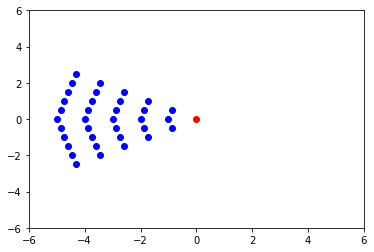

In [79]:
plt.scatter(np.array(rot_node_poses)[:,0], np.array(rot_node_poses)[:,2], color='b')
plt.scatter(pos[0], pos[2], color='r')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show()

In [ ]:
def get_cand_node_dirc(self, pano_rgb, depth, pos, rot, vis_pos=None):

    ## rot is rotation vector
    cur_heading_idx = int(np.round(-rot[1] * 180 / np.pi / self.cand_rot_angle)) % self.rot_num
    cand_nodes = []
    cand_angle = [-30, 0, 30]
    self.local_mapper.reset_map()
    depth_cm = depth * 100
    pose_origin_for_map = (pos[0], pos[2], 0)  # (x, y, o)
    pose_for_map = (pos[0], pos[2], rot[1])  # (x, y, o)
    pose_on_map_cm = self.local_mapper.get_mapper_pose_from_sim_pose(pose_for_map, pose_origin_for_map)
    pose_on_map = self.local_mapper.get_map_grid_from_sim_pose_cm(pose_on_map_cm)

    ### get current local map ###
    curr_local_map, curr_exp_map, _ = self.local_mapper.update_map(depth_cm, pose_on_map_cm)
    curr_local_map = (skimage.morphology.binary_dilation(
        curr_local_map, skimage.morphology.disk(2)
    )== True).astype(float)

    # text = goal_info['category_place']
    rot_axis = np.array([0, 1, 0])
    # head = -quaternion.as_rotation_vector(rot)[1] * 180 / np.pi

    # for global coordinate
    # turn left = positive angle
    # free cand angle idx --> right side is positive
    free_cand_nodes = np.zeros(12)
    angle_bias = np.where(self.cand_angle == -30)[0][0]

    for i, angle in enumerate(cand_angle):
        rot_vec = rot + np.radians(-angle) * rot_axis
        unit_vec = -np.array([np.sin(rot_vec[1]), 0, np.cos(rot_vec[1])])
        cand_pos = pos + unit_vec * self.edge_range
        cand_rot = rot_vec
        cur_heading_idx = int(np.round(-rot_vec[1] * 180 / np.pi / self.cand_rot_angle)) % self.rot_num

        ## map coordinate for checking free space
        cand_pose_for_map = (cand_pos[0], cand_pos[2], rot_vec[1])
        cand_pose_on_grid_map_cm = self.local_mapper.get_mapper_pose_from_sim_pose(cand_pose_for_map, pose_origin_for_map)
        cand_pose_on_grid_map = self.local_mapper.get_map_grid_from_sim_pose_cm(cand_pose_on_grid_map_cm)
        if self.local_mapper.is_traversable(curr_local_map, pose_on_map, cand_pose_on_grid_map):
            cand_node_info = {'position': cand_pos, 'rotation': cand_rot, 'heading_idx': cur_heading_idx,
                              'pose_on_map': cand_pose_on_grid_map, 'cand_edge': [],}

            if self.vis_floorplan:
                vis_rot_vec = rot_vec + self.abs_init_rotation
                vis_unit_vec = -np.array([np.sin(vis_rot_vec[1]), 0, np.cos(vis_rot_vec[1])])
                vis_cand_pos = vis_pos + vis_unit_vec * self.edge_range
                cand_node_info['vis_position'] = vis_cand_pos

            cand_node_info['next_node'] = None

            cand_nodes.append(cand_node_info)
            free_cand_nodes[angle_bias + i] = 1

    # cand_nodes.append({'position': cand_pos, 'rotation': cand_rot})
    #
    pano_split_images = self.get_dirc_imgs_from_pano(pano_rgb)
    cand_split_images = pano_split_images[np.where(free_cand_nodes == 1)[0]]

    valid_cand_nodes = []
    # similarity, cand_split_feat = self.common_sense_model.clip.get_text_image_sim(text, cand_split_images,
    #                                                                               out_img_feat=True)
    if len(cand_split_images) > 0:
        cand_image_feat = self.common_sense_model.clip.get_image_feat(cand_split_images)
        # cm_score, _ = self.common_sense_model.text_image_score(self.goal_place_text_feat, cand_image_feat, feat=True)
        for i in range(len(cand_nodes)):
            cand_nodes[i]['clip_feat'] = cand_image_feat[i]

            for j in range(i + 1, len(cand_nodes)):
                if self.local_mapper.is_traversable(curr_local_map, cand_nodes[i]['pose_on_map'],
                                                    cand_nodes[j]['pose_on_map']):
                    cand_nodes[i]['cand_edge'].append(j)

            # if cand_nodes[i]['next_node'] is not None:
            #     cand_nodes[i]['next_node']['clip_feat'] = cand_image_feat[i]
            # cand_nodes[i]['cm_score'] = cm_score[i]
            valid_cand_nodes.append(cand_nodes[i])

    return valid_cand_nodes